Experimental Identification of Physically Feasible Dynamic Parameters of the 7-link xMate7p Robot using LMI–SDP Techniques
=======================================================================================================================

[![DOI](https://zenodo.org/badge/920/cdsousa/wam7_dyn_ident.png)](http://dx.doi.org/10.5281/zenodo.10537)

*Experimental code and data associated with the paper:*

**Cristóvão D. Sousa and Rui Cortesão, "Physical feasibility of robot base inertial parameter identification: A linear matrix inequality approach," The International Journal of Robotics Research, vol. 33, no. 6, pp. 931–944, May. 2014, doi: [10.1177/0278364913514870](http://dx.doi.org/10.1177/0278364913514870)**

[Postprint availabe from ResearchGate](http://www.researchgate.net/publication/262483999_Physical_feasibility_of_robot_base_inertial_parameter_identification_A_linear_matrix_inequality_approach)

------------------------


Authors
-------

- Cristóvão D. Sousa, [crisjss@gmail.com](mailto:crisjss@gmail.com)
- Rui Cortesão, [cortesao@isr.uc.pt](mailto:cortesao@isr.uc.pt)

------------------------


Research Notebook
-----------------

The research is done in [Python](http://www.python.org/) within an [IPython notebook](http://ipython.org/notebook.html) (the *xMate7p Dynamic Parameter Identification V1.ipynb* file).
Data is in *data* folder. Additional Python support code is in *support_funcs* folder.




How to run the code
-------------------

- clone the git repository (it contains code and data)
- open the *xMate7p Dynamic Parameter Identification V1.ipynb* notebook with [IPython](http://ipython.org/)
- edit and run the code

Dependencies:

- [Python](http://www.python.org/)
- [IPython](http://ipython.org/)
- [SymPy](http://sympy.org/)
- [Numpy](http://www.numpy.org/)
- [SciPy](http://www.scipy.org/)
- [SymPyBotics](https://github.com/cdsousa/SymPyBotics)
- [PyLMI-SDP](https://github.com/cdsousa/PyLMI-SDP)

------------------------


Questions & Feedback
--------------------

Feel free to contact the authors at [crisjss@gmail.com](mailto:crisjss@gmail.com)

------------------------


License
-------

Copyright (c) 2013, Cristóvão Duarte Sousa, Rui Cortesão

All rights reserved.

[![Creative Commons License](http://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png)](http://creativecommons.org/licenses/by-nc-sa/4.0/)
This work is licensed under a [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-nc-sa/4.0/)


---------------

---------------

---------------

---------------

# Initializations

In [429]:
%load_ext autoreload
%autoreload 1
%aimport support_funcs.regr_data_proc

datafolder = 'data/'
tmpfolder = 'tmp/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [430]:
from sympy import init_printing
init_printing()

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/hzx/anaconda3/envs/sousa/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['eye', 'sin', 'beta', 'cos', 'test', 'table']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


1 - Robot Model
===============

In [431]:
import sympybotics

#### Robot Definition

In [432]:
rbtdef = sympybotics.RobotDef("xMate7p",
            [(0,       0,      0.404, "q"),
             ("-pi/2", 0,          0, "q"),
             ("pi/2",  0,     0.4375, "q"),
             ("-pi/2", 0,          0, "q"),
             ("pi/2",  0,     0.4125, "q"),
             ("-pi/2", 0,          0, "q"),
             ("pi/2",  0,     0.2755, "q")],
            dh_convention="modified")   # # (alpha, a, d, theta)

# rbtdef.frictionmodel = {}    # 摩擦力模型

# rbtdef.frictionmodel = {'Coulomb', 'viscous'}
# rbtdef.driveinertiamodel = 'simplified'

rbtdef.frictionmodel = {'Coulomb', 'viscous'}
rbtdef.driveinertiamodel = 'simplified'

#### Model Generation

In [433]:
%time rbt = sympybotics.RobotDynCode(rbtdef)
%time rbt.calc_base_parms()

CPU times: user 5.88 s, sys: 40 ms, total: 5.92 s
Wall time: 5.88 s
CPU times: user 6.62 s, sys: 127 ms, total: 6.75 s
Wall time: 4.83 s


In [434]:
import pickle
with open(tmpfolder + 'robotmodels/xMate7p.pkl', 'wb') as file:
    pickle.dump( rbt, file )

## Base Dynamic Parameters

In [435]:
import pickle
with open(tmpfolder +  'robotmodels/xMate7p.pkl', 'rb' ) as file:
          rbt = pickle.load( file )

In [436]:
rbt.dyn.n_dynparms, rbt.dyn.n_base

(91, 62)

In [437]:
rbt.dyn.baseparms.n()

Matrix([
[                                                                                                   Ia_1 + L_1zz + L_2yy],
[                                                                                                                   fv_1],
[                                                                                                                   fc_1],
[L_2xx - L_2yy + L_3yy + 0.875*l_3z + 0.19140625*m_3 + 0.19140625*m_4 + 0.19140625*m_5 + 0.19140625*m_6 + 0.19140625*m_7],
[                                                                                                                  L_2xy],
[                                                                                                                  L_2xz],
[                                                                                                                  L_2yz],
[ Ia_2 + L_2zz + L_3yy + 0.875*l_3z + 0.19140625*m_3 + 0.19140625*m_4 + 0.19140625*m_5 + 0.19140625*m_6 + 0.19140625*m_7],
[      

2 - Excited Trajectory Optimization
==================================

In [438]:
import pickle
with open(tmpfolder +  'robotmodels/xMate7p.pkl', 'rb' ) as file:
          rbt = pickle.load( file )

In [439]:
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from numpy import deg2rad

trajectory_folder =  'data/trajectories/'

# 周期是20
base_freq = 0.05
fourier_order = 5

joint_constraints = []

# 关节约束[关节序号，位置约束，速度约束，加速度约束]
joint_constraints = [(1, deg2rad(-165), deg2rad(165), -2.175, 2.175, -15, 15),
                     (2, deg2rad(-115), deg2rad(115), -2.175, 2.175, -7.5, 7.5),
                     (3, deg2rad(-165), deg2rad(165), -2.175, 2.175, -10, 10),
                     (4, deg2rad(-115), deg2rad(115), -2.175, 2.175, -10, 10),
                     (5, deg2rad(-165), deg2rad(165), -2.610, 2.610, -15, 15),
                     (6, deg2rad(-115), deg2rad(115), -2.610, 2.610, -15, 15),
                     (7, deg2rad(-355), deg2rad(355), -2.610, 2.610, -20, 20)]


# # 关节约束[关节序号，位置约束，速度约束，加速度约束]
# joint_constraints = [(1, deg2rad(-165), deg2rad(165), -2.175, 2.175),
#                      (2, deg2rad(-115), deg2rad(115), -2.175, 2.175),
#                      (3, deg2rad(-165), deg2rad(165), -2.175, 2.175),
#                      (4, deg2rad(-115), deg2rad(115), -2.175, 2.175),
#                      (5, deg2rad(-165), deg2rad(165), -2.610, 2.610),
#                      (6, deg2rad(-115), deg2rad(115), -2.610, 2.610),
#                      (7, deg2rad(-355), deg2rad(355), -2.610, 2.610)]

traj_optimizer = TrajOptimizer(rbt, fourier_order, base_freq,
                               joint_constraints=joint_constraints)
                                                                                                                                                                                                                
traj_optimizer.x_result = np.load(trajectory_folder+"opt_x.npy")
# traj_optimizer.optimize()

dof_num: 7
joint constraint number: 42
cartesian constraint number: 0
constraint number: 42
frames_constrained: []


## plot excited trajectory

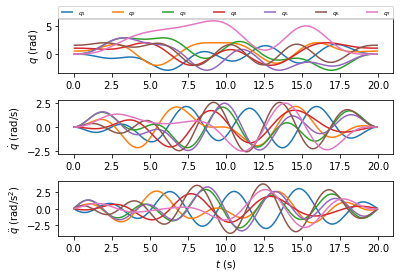

In [440]:
# %matplotlib qt 

traj_plotter = TrajPlotter(traj_optimizer.fourier_traj,traj_optimizer.frame_traj,
                           traj_optimizer.const_frame_ind)
traj_plotter.plot_desired_traj(traj_optimizer.x_result, trajectory_folder)

## save trajectory

In [441]:
from utils import save_data, load_data

trajectory_name = 'xMate7p'

dof_order_bf_x_norm = (traj_optimizer.fourier_traj.dof, fourier_order,
                       base_freq, traj_optimizer.x_result, [])
save_data(trajectory_folder, trajectory_name, dof_order_bf_x_norm)

freq = 50
tf = 105 # including 5 seconds' prestable time
traj_optimizer.make_traj_csv(trajectory_folder, trajectory_name, freq, tf)


# save as .npy format in order to skip the optimizer
np.save(trajectory_folder+"opt_x.npy", traj_optimizer.x_result)

# save as .txt format for xMate7 pro robot
opt_x = [0]*traj_optimizer.fourier_traj.dof*(2*fourier_order+1)
for i in range(traj_optimizer.fourier_traj.dof):
    opt_x[i*11] = traj_optimizer.x_result.tolist()[i*11+1]
    opt_x[i*11+1] = traj_optimizer.x_result.tolist()[i*11+6]
    opt_x[i*11+2] = traj_optimizer.x_result.tolist()[i*11+2]
    opt_x[i*11+3] = traj_optimizer.x_result.tolist()[i*11+7]
    opt_x[i*11+4] = traj_optimizer.x_result.tolist()[i*11+3]
    opt_x[i*11+5] = traj_optimizer.x_result.tolist()[i*11+8]
    opt_x[i*11+6] = traj_optimizer.x_result.tolist()[i*11+4]
    opt_x[i*11+7] = traj_optimizer.x_result.tolist()[i*11+9]
    opt_x[i*11+8] = traj_optimizer.x_result.tolist()[i*11+5]
    opt_x[i*11+9] = traj_optimizer.x_result.tolist()[i*11+10]
    opt_x[i*11+10] = traj_optimizer.x_result.tolist()[i*11+0]

# list_txt(path=trajectory_folder+'opt_x.txt', list=opt_x)
f1 = open(trajectory_folder+'opt_x.txt','w')
for j in opt_x:
    f1.write(str(j)+'\n')
f1.close()
q, dq, ddq = traj_optimizer.fourier_traj.fourier_base_x2q(traj_optimizer.x_result)
q[0]

array([-4.82916904e-06,  5.23596413e-01,  1.37229307e-06,  1.04719678e+00,
        7.87726298e-08,  1.57079639e+00,  8.11783698e-08])

## display trajectory param

In [442]:
from IPython.display import HTML, display
import tabulate

table = []
table.append(["joint", 'qo'] +
             ["a"+str(i+1) for i in range(fourier_order)] +
             ["b"+str(i+1) for i in range(fourier_order)])
for i in range(traj_optimizer.fourier_traj.dof):
    line = []
    line.append(rbt.rbtdef.q[i])
    line += np.round(traj_optimizer.x_result[i*(1 + fourier_order*2): (i+1)*(1 + fourier_order*2)], 4).tolist()
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

joint,qo,a1,a2,a3,a4,a5,b1,b2,b3,b4,b5
q1,-0.3539,-0.279,0.0057,-0.211,-0.5009,0.9852,-0.1038,-0.3361,0.241,0.8687,-0.6844
q2,0.5707,-0.0525,-0.1808,0.7247,0.1709,-0.6634,-0.0046,-0.5089,1.0307,0.1451,-0.53
q3,0.4304,0.6088,0.6038,-0.5058,0.4032,-1.1101,0.1377,0.1008,-0.0157,-0.3998,0.2614
q4,0.3987,0.0479,-0.1241,-0.4313,0.4425,0.065,-0.3813,0.1297,0.8641,-0.8496,0.1856
q5,-0.3251,0.5573,0.5621,-0.6522,0.6892,-1.1565,-0.2269,0.1727,0.3031,-0.2388,-0.0145
q6,0.4889,0.2006,0.3843,0.0493,0.1479,-0.7822,-0.242,0.0325,0.0177,-1.3887,1.1358
q7,2.8145,0.1887,-0.6329,0.7967,-0.0096,-0.3429,0.6124,0.5486,0.7155,-0.9636,-0.0003


3 - Regression Data Processing
==============================

In [443]:
import os
import pickle
import math
import sympy
import numpy
import sympybotics

In [444]:
with open(tmpfolder +  'robotmodels/xMate7p.pkl', 'rb' ) as file:
          rbt = pickle.load( file )

### Data Load

In [445]:
parms_traj = 'traj1'

In [446]:
from support_funcs.regr_data_proc import load_trajectory_data

training_results_data_file = datafolder +'recdata/' + 'xMate7p_'+parms_traj+'_results.csv'

trajectory_sampling_rate = 50    # 实际机器人数据采样频率，用于计算时间
t_raw, q_raw, dq_raw, ddq_raw, tau_raw = load_trajectory_data(training_results_data_file,
                                                                   trajectory_sampling_rate)
t_raw.shape

(<type 'numpy.ndarray'>, (1001, 28))


(1001,)

### Some Plots

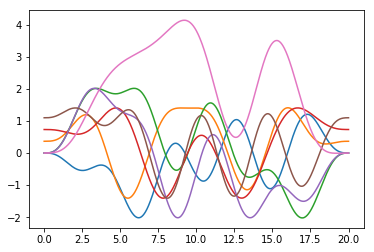

In [447]:
from matplotlib import pyplot as plt
plt.close()

# for d in range(rbt.dof):
#     co_num = str(d + 1)
#     plt.plot(t_raw, q_raw[:, d], label=(r"$q_" + co_num +"$"), linestyle= (0, ()))
    
for i in range(q_raw.shape[1]):
    plt.plot(t_raw,q_raw[:,i])

plt.show()

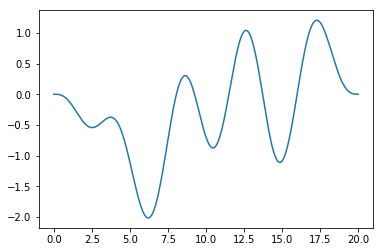

In [448]:
from matplotlib import pyplot as plt
plt.close()

joint = 1
# plt.plot(t_ref+0.20,q_ref[:,joint-1])
plt.plot(t_raw,q_raw[:,joint-1])

plt.show()

In [449]:
del t_raw, q_raw, dq_raw,tau_raw

### Parameter Load

In [450]:
from utils import save_data, load_data

training_trajectory_name = 'xMate7p'


trajectory_folder = datafolder +'trajectories/'
dof, fourier_order, base_freq, traj_optimizer_result, reg_norm_mat = load_data(trajectory_folder,
                                                                               training_trajectory_name)
print("dof: {}".format(dof))
print("Fourier order: {}".format(fourier_order))
print("Base frequency: {}".format(base_freq))

dof: 7
Fourier order: 5
Base frequency: 0.05


### Filter Cut-off Frequency Definition

In [451]:
# times of the highest frequency in the Fourier series
fc_mult = 10.0

fc = base_freq * fourier_order * fc_mult
print("Cut frequency: {}".format(fc))

Cut frequency: 2.5


In [452]:
fc_q = fc
fc_dq = fc
fc_ddq = fc

fc_tau = float('Inf')  # fc

# si = 200
# sf = -200

si = int(3/0.02)
sf = -int(1/0.02)


# si = int(3/0.001)
# sf = -int(1/0.001)

### Data Filtering, Differentiation and Regression Data Generation

In [453]:
rec_h = 0.02

In [454]:
from support_funcs.regr_data_proc import load_trajectory_data, plot_trajectory_data, \
                                            diff_and_filt_data, gen_regr_matrices


def process_regression_data(traj_name):
#     t_raw, q_raw, tau_raw, t_ref, q_ref = read_data(dof=rbt.dof, h=rec_h,
#                                                     rbtlogfile=datafolder + 'recdata/rbtlog_%s.dat'%traj_name,
#                                                     trajreffile=datafolder + 'trajectories/%s.dat'%traj_name)
    
    training_results_data_file = datafolder +'recdata/' + 'xMate7p_%s_results.csv'%traj_name
    trajectory_sampling_rate = 50    # 实体机器人运行,记录数据采样频率
    t_raw, q_raw, dq_raw, ddq_raw, tau_raw = load_trajectory_data(training_results_data_file,
                                                                   trajectory_sampling_rate)
    
    # 原始采集数据滤波
    q, dq, ddq, tau = diff_and_filt_data(dof=rbt.dof, h=rec_h,  q_raw=q_raw, dq_raw=dq_raw, ddq_raw=ddq_raw,
                                         tau_raw=tau_raw,fc_q=fc_q, fc_dq=fc_dq, fc_ddq=fc_ddq, fc_tau=fc_tau)
    
    # 掐头去尾留中间，可能是因为开始和结束时抖动？
    t_raw = t_raw[si:sf]; q_raw = q_raw[si:sf]; tau_raw = tau_raw[si:sf]
    q = q[si:sf]; dq = dq[si:sf]; ddq = ddq[si:sf]; tau = tau[si:sf]
    
    
    t_raw = t_raw - t_raw[0]
    
    t = numpy.array(range(q.shape[0])) * rec_h
    
    W, omega, Q1, R1, rho1 = gen_regr_matrices(rbt, q, dq, ddq, tau)
    
    # t_raw, q_raw, tau_raw是原始采集数据，t, q, dq, ddq, tau是滤波后的数据
    return t_raw, q_raw, tau_raw, t, q, dq, ddq, tau, W, omega, Q1, R1, rho1

In [455]:
from support_funcs.utils import _fprint
from support_funcs.regr_data_proc import plot_trajectory_data

for traj in ['traj1', 'traj2', 'traj3']:      #, 'traj4'
    _fprint('>>>>>>>> %s proc <<<<<<<<<'%traj)
    %time t_raw, q_raw, tau_raw, t, q, dq, ddq, tau, W, omega, Q1, R1, rho1 = process_regression_data(traj)
    
    _fprint(' (cond=%f)'%numpy.linalg.cond(W))
    
    _fprint('%s save'%traj)
    
    %time \
    numpy.savez_compressed(tmpfolder + 'procdata/' + traj + '_raw', t=t_raw, q=q_raw, tau=tau_raw);\
    numpy.savez_compressed(tmpfolder + 'procdata/' + traj + '_proc', t=t, q=q, dq=dq, ddq=ddq, tau=tau); \
    numpy.savez_compressed(tmpfolder + 'procdata/' + traj + '_regr', W=W, omega=omega, Q1=Q1, R1=R1, rho1=rho1)
    
#     plot_trajectory_data(t, q_raw, q, dq, ddq,
#                      tau_raw, tau)
    
    del t_raw, q_raw, tau_raw, t, q, dq, ddq, tau, W, omega, Q1, R1, rho1

>>>>>>>> traj1 proc <<<<<<<<<
(<type 'numpy.ndarray'>, (1001, 28))
CPU times: user 1.03 s, sys: 15.8 ms, total: 1.04 s
Wall time: 370 ms
 (cond=59.697022)
traj1 save
CPU times: user 768 ms, sys: 8.08 ms, total: 776 ms
Wall time: 136 ms
>>>>>>>> traj2 proc <<<<<<<<<
(<type 'numpy.ndarray'>, (1001, 28))
CPU times: user 1.27 s, sys: 32.6 ms, total: 1.3 s
Wall time: 344 ms
 (cond=86.257728)
traj2 save
CPU times: user 751 ms, sys: 27.6 ms, total: 778 ms
Wall time: 138 ms
>>>>>>>> traj3 proc <<<<<<<<<
(<type 'numpy.ndarray'>, (1001, 28))
CPU times: user 1.25 s, sys: 7.58 ms, total: 1.26 s
Wall time: 346 ms
 (cond=86.227975)
traj3 save
CPU times: user 768 ms, sys: 23.2 ms, total: 792 ms
Wall time: 141 ms


### Plot

In [456]:
raw = numpy.load(tmpfolder + 'procdata/traj1_raw.npz')
tau_raw = raw['tau']
q_raw = raw['q']
del raw
proc = numpy.load(tmpfolder + 'procdata/traj1_proc.npz')
t = proc['t']
tau = proc['tau']
q = proc['q']
dq = proc['dq']
del proc

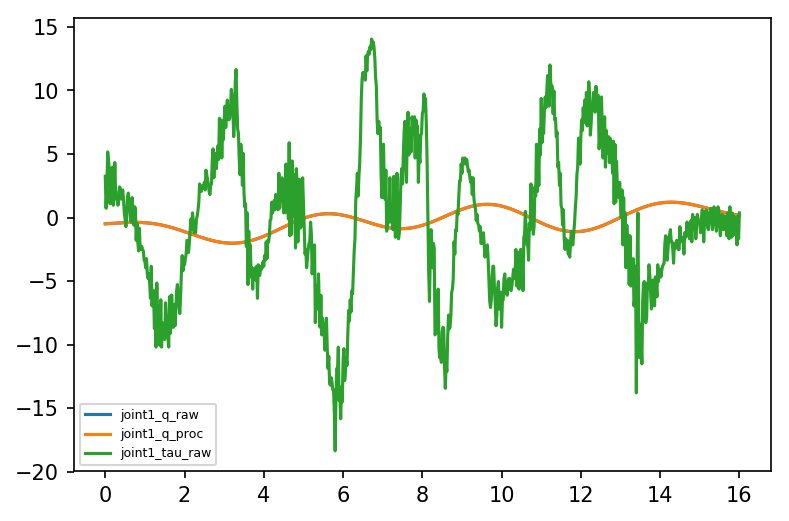

In [457]:
from matplotlib import pyplot as plt
plt.close()

plt.figure(dpi=150)
joint = 1
firsts = 20000
plt.plot(t[:firsts],q_raw[:,joint-1][:firsts],label='joint'+str(joint)+'_q_raw')
plt.plot(t[:firsts],q[:,joint-1][:firsts],label='joint'+str(joint)+'_q_proc')
#plt.plot(t[:firsts],dq[:,joint-1][:firsts])
plt.plot(t[:firsts],tau_raw[:,joint-1][:firsts],label='joint'+str(joint)+'_tau_raw')
plt.rc('legend', fontsize=6)
plt.legend(loc=3)

plt.show()

In [458]:
del t, q, dq, tau, q_raw, tau_raw

4 - Dynamic Parameter Estimation
================================

In [459]:
import os
import pickle
import sympy
import numpy
import time

import sympybotics
import lmi_sdp

from lmi_sdp import init_lmi_latex_printing
init_lmi_latex_printing()

In [460]:
with open(tmpfolder +  'robotmodels/xMate7p.pkl', 'rb' ) as file:
          rbt = pickle.load( file )

In [461]:
epsilon_safemargin = 1e-30
epsilon_sdptol = 1e-7

## LMI Matrix Definitions

In [462]:
dof = rbt.dof

delta = rbt.dyn.dynparms    # 要辨识的全参数集矩阵表达式
n_delta = rbt.dyn.n_dynparms    # 要辨识的全参数集参数数量

beta = rbt.dyn.baseparms.n()    # 最小参数集矩阵表达式
n_beta = rbt.dyn.n_base         # 最小参数集参数数量
beta_symbs = sympy.Matrix([sympy.Symbol('beta'+str(i+1),real=True) for i in range(n_beta)])

delta_d = (rbt.dyn.Pd.T*delta)  # beta中非独立部分
n_delta_d = len(delta_d)

K = rbt.dyn.Pb.T + rbt.dyn.Kd * rbt.dyn.Pd.T

Pb = rbt.dyn.Pb

varchange_dict = dict(zip(Pb.T*delta ,  beta_symbs - ( beta - Pb.T*delta )))

In [463]:
from support_funcs.utils import skew, mrepl
from sympy import BlockMatrix, Matrix, eye, Identity
I = Identity
S = skew

In [464]:
D_inertia_blocks = []
# `L` is the link inertia tensor computed about the link frame;
# `l` is the link first moment of inertia;
# `m` is the link mass.
for i in range(dof):
    L = rbt.rbtdef.L[i]
    l = rbt.rbtdef.l[i]
    m = rbt.rbtdef.m[i]
    Di = BlockMatrix([[L,    S(l).T],
                      [S(l), I(3)*m]])
    D_inertia_blocks.append(Di.as_explicit())

In [465]:
D_inertia_blocks[0]

Matrix([
[L_1xx, L_1xy, L_1xz,     0,  l_1z, -l_1y],
[L_1xy, L_1yy, L_1yz, -l_1z,     0,  l_1x],
[L_1xz, L_1yz, L_1zz,  l_1y, -l_1x,     0],
[    0, -l_1z,  l_1y,   m_1,     0,     0],
[ l_1z,     0, -l_1x,     0,   m_1,     0],
[-l_1y,  l_1x,     0,     0,     0,   m_1]])

In [466]:
F_blocks = []
for i in range(dof):
    if rbt.rbtdef.driveinertiamodel == 'simplified':
        F_blocks.append( Matrix([rbt.rbtdef.Ia[i]]) )
    if 'viscous' in rbt.rbtdef.frictionmodel:
        F_blocks.append( Matrix([rbt.rbtdef.fv[i]]) )
    if 'Coulomb' in rbt.rbtdef.frictionmodel:
        F_blocks.append( Matrix([rbt.rbtdef.fc[i]]) )

In [467]:
E_blocks = D_inertia_blocks + F_blocks

In [468]:
E_blocks

[Matrix([
 [L_1xx, L_1xy, L_1xz,     0,  l_1z, -l_1y],
 [L_1xy, L_1yy, L_1yz, -l_1z,     0,  l_1x],
 [L_1xz, L_1yz, L_1zz,  l_1y, -l_1x,     0],
 [    0, -l_1z,  l_1y,   m_1,     0,     0],
 [ l_1z,     0, -l_1x,     0,   m_1,     0],
 [-l_1y,  l_1x,     0,     0,     0,   m_1]]), Matrix([
 [L_2xx, L_2xy, L_2xz,     0,  l_2z, -l_2y],
 [L_2xy, L_2yy, L_2yz, -l_2z,     0,  l_2x],
 [L_2xz, L_2yz, L_2zz,  l_2y, -l_2x,     0],
 [    0, -l_2z,  l_2y,   m_2,     0,     0],
 [ l_2z,     0, -l_2x,     0,   m_2,     0],
 [-l_2y,  l_2x,     0,     0,     0,   m_2]]), Matrix([
 [L_3xx, L_3xy, L_3xz,     0,  l_3z, -l_3y],
 [L_3xy, L_3yy, L_3yz, -l_3z,     0,  l_3x],
 [L_3xz, L_3yz, L_3zz,  l_3y, -l_3x,     0],
 [    0, -l_3z,  l_3y,   m_3,     0,     0],
 [ l_3z,     0, -l_3x,     0,   m_3,     0],
 [-l_3y,  l_3x,     0,     0,     0,   m_3]]), Matrix([
 [L_4xx, L_4xy, L_4xz,     0,  l_4z, -l_4y],
 [L_4xy, L_4yy, L_4yz, -l_4z,     0,  l_4x],
 [L_4xz, L_4yz, L_4zz,  l_4y, -l_4x,     0],
 [    0, -l_

## Change of Variable Space

In [469]:
varchange_dict = dict(zip(Pb.T*delta ,  beta_symbs - ( beta - Pb.T*delta )))

In [470]:
EB_blocks = [mrepl(Ei, varchange_dict) for Ei in E_blocks]
EB_blocks

[Matrix([
 [L_1xx, L_1xy,                 L_1xz,     0,  l_1z, -l_1y],
 [L_1xy, L_1yy,                 L_1yz, -l_1z,     0,  l_1x],
 [L_1xz, L_1yz, -Ia_1 - L_2yy + beta1,  l_1y, -l_1x,     0],
 [    0, -l_1z,                  l_1y,   m_1,     0,     0],
 [ l_1z,     0,                 -l_1x,     0,   m_1,     0],
 [-l_1y,  l_1x,                     0,     0,     0,   m_1]]), Matrix([
 [L_2yy - L_3yy + beta4 - 0.875*l_3z - 0.19140625*m_3 - 0.19140625*m_4 - 0.19140625*m_5 - 0.19140625*m_6 - 0.19140625*m_7, beta5,                                                                                                                   beta6,                                                                              0,   l_2z, -beta10 - l_3z - 0.4375*m_3 - 0.4375*m_4 - 0.4375*m_5 - 0.4375*m_6 - 0.4375*m_7],
 [                                                                                                                  beta5, L_2yy,                                                               

## LMI Definitions

In [471]:
from lmi_sdp import LMI_PD, LMI

In [472]:
EB_LMIs = list(map(LMI_PD, EB_blocks))

In [473]:
EB_LMIs[0]

Matrix([
[L_1xx, L_1xy,                 L_1xz,     0,  l_1z, -l_1y],
[L_1xy, L_1yy,                 L_1yz, -l_1z,     0,  l_1x],
[L_1xz, L_1yz, -Ia_1 - L_2yy + beta1,  l_1y, -l_1x,     0],
[    0, -l_1z,                  l_1y,   m_1,     0,     0],
[ l_1z,     0,                 -l_1x,     0,   m_1,     0],
[-l_1y,  l_1x,                     0,     0,     0,   m_1]]) > 0

In [474]:
EB_LMIs_marg = list(map(lambda lm: LMI(lm, epsilon_safemargin*eye(lm.shape[0])) , EB_blocks))

In [475]:
EB_LMIs_marg[0]

Matrix([
[L_1xx, L_1xy,                 L_1xz,     0,  l_1z, -l_1y],
[L_1xy, L_1yy,                 L_1yz, -l_1z,     0,  l_1x],
[L_1xz, L_1yz, -Ia_1 - L_2yy + beta1,  l_1y, -l_1x,     0],
[    0, -l_1z,                  l_1y,   m_1,     0,     0],
[ l_1z,     0,                 -l_1x,     0,   m_1,     0],
[-l_1y,  l_1x,                     0,     0,     0,   m_1]]) >= Matrix([
[1.0e-30,       0,       0,       0,       0,       0],
[      0, 1.0e-30,       0,       0,       0,       0],
[      0,       0, 1.0e-30,       0,       0,       0],
[      0,       0,       0, 1.0e-30,       0,       0],
[      0,       0,       0,       0, 1.0e-30,       0],
[      0,       0,       0,       0,       0, 1.0e-30]])

In [476]:
EB_LMIs_marg[0].canonical()

Matrix([
[L_1xx - 1.0e-30,           L_1xy,                           L_1xz,             0,          l_1z,         -l_1y],
[          L_1xy, L_1yy - 1.0e-30,                           L_1yz,         -l_1z,             0,          l_1x],
[          L_1xz,           L_1yz, -Ia_1 - L_2yy + beta1 - 1.0e-30,          l_1y,         -l_1x,             0],
[              0,           -l_1z,                            l_1y, m_1 - 1.0e-30,             0,             0],
[           l_1z,               0,                           -l_1x,             0, m_1 - 1.0e-30,             0],
[          -l_1y,            l_1x,                               0,             0,             0, m_1 - 1.0e-30]]) >= 0

## SDP Solver Interfaces

### [SDPA](http://sdpa.sourceforge.net/)

In [477]:
def sdpa(objf, lmis, variables):
    sdpadat = lmi_sdp.to_sdpa_sparse(objf, lmis, variables)
    with open(tmpfolder + 'sdpa_dat/sdp.dat-s', 'w') as f:
        f.write(sdpadat)
    
    stdout = !sdpa -ds "$tmpfolder"sdpa_dat/sdp.dat-s -o "$tmpfolder"sdpa_dat/sdpa.out -p "$tmpfolder"sdpa_dat/param.sdpa -pt 2
    print('\n'.join(stdout))

    outfile = !cat "$tmpfolder"sdpa_dat/sdpa.out
    sol = [float(v) for v in outfile[outfile.index('xVec = ') + 1].replace('{', '').replace('}', '').split(',')]
    return numpy.matrix(sol).T

### [CSDP](https://projects.coin-or.org/Csdp/)

In [478]:
def csdp(objf, lmis, variables):
    sdpadat = lmi_sdp.to_sdpa_sparse(objf, lmis, variables)
    with open(tmpfolder + 'sdpa_dat/sdp.dat-s', 'w') as f:
        f.write(sdpadat)
    
    stdout = !cd "$tmpfolder"sdpa_dat; csdp sdp.dat-s csdp.out
    print('\n'.join(stdout))

    outfile = !cat "$tmpfolder"sdpa_dat/csdp.out
    sol = [float(v) for v in outfile[0].split()]
    return numpy.matrix(sol).T

### [DSDP5](doi.org/10.1145/1356052.1356057)

In [479]:
def dsdp5(objf, lmis, variables):
    sdpadat = lmi_sdp.to_sdpa_sparse(objf, lmis, variables)
    with open(tmpfolder + 'sdpa_dat/sdp.dat-s', 'w') as f:
        f.write(sdpadat)
    
    stdout = !cd "$tmpfolder"sdpa_dat; dsdp5 sdp.dat-s -save dsdp5.out -gaptol $epsilon_sdptol
    print('\n'.join(stdout))

    outfile = !cat "$tmpfolder"sdpa_dat/dsdp5.out
    sol = [float(v) for v in outfile[0].split()]
    return numpy.matrix(sol).T

### [DSDP5 through CVXOPT](http://abel.ee.ucla.edu/cvxopt/userguide/coneprog.html#cvxopt.solvers.sdp)

In [480]:
def cvxopt_dsdp5(objf, lmis, variables):
    import cvxopt.solvers
    c, Gs, hs = lmi_sdp.to_cvxopt(objf, lmis, variables)
    cvxopt.solvers.options['DSDP_GapTolerance'] = epsilon_sdptol
    tic = time.time()
    sdpout = cvxopt.solvers.sdp(c, Gs=Gs, hs=hs, solver='dsdp')
    toc = time.time()
    print(sdpout['status'], ('ATT!: \'optimal\' does not necessarlly means feasible'))
    print('Elapsed time: %.2f s'%(toc-tic))
    return numpy.matrix(sdpout['x'])

### [CVXOPT CONELP](http://abel.ee.ucla.edu/cvxopt/userguide/coneprog.html#cvxopt.solvers.sdp)

In [481]:
def cvxopt_conelp(objf, lmis, variables):
    import cvxopt.solvers
    c, Gs, hs = lmi_sdp.to_cvxopt(objf, lmis, variables)
    cvxopt.solvers.options['feastol'] = epsilon_sdptol
    tic = time.time()
    sdpout = cvxopt.solvers.sdp(c, Gs=Gs, hs=hs)
    toc = time.time()
    print(sdpout['status'])
    print('Elapsed time: %.2f s'%(toc-tic))
    return numpy.matrix(sdpout['x'])

### [Raw SDPA file](http://plato.asu.edu/ftp/sdpa_format.txt)

Can be solved online with a *Semidefinite Programming* solver at [NEOS Solvers](http://www.neos-server.org/neos/solvers/index.html)

In [482]:
def sdpa_file(objf, lmis, variables):
    sdpadat = lmi_sdp.to_sdpa_sparse(objf, lmis, variables)
    with open(tmpfolder + 'sdpa_dat/sdpa_input.dat-s', 'w') as f:
        f.write(sdpadat)
        
    print("SDPA file saved at: %ssdpa_dat/sdpa_input.dat-s"%tmpfolder)

--------------

Setting the default SDP solver:

In [483]:
solve_sdp = dsdp5

## Method 1:Ordinary Least Squares (OLS)

In [484]:
indentification_traj = 'traj1'

In [485]:
regr_mats = numpy.load(tmpfolder + 'procdata/' + indentification_traj + '_regr.npz')
W = numpy.matrix(regr_mats['W'])
omega = numpy.matrix(regr_mats['omega'])
R1 = numpy.matrix(regr_mats['R1'])
rho1 = numpy.matrix(regr_mats['rho1'])

In [486]:
omega.shape[0] / rbt.dof

801

In [487]:
W.shape

(5607, 62)

In [488]:
numpy.linalg.cond(W)

59.697022045014265

In [489]:
%time beta_ols = (R1.T * R1).I * R1.T * rho1

CPU times: user 8.84 ms, sys: 0 ns, total: 8.84 ms
Wall time: 1.83 ms


In [490]:
numpy.savetxt(tmpfolder + 'solutions/V1_' + indentification_traj + '_beta_ols.dat', beta_ols)

In [491]:
rho2_norm_sqr = numpy.linalg.norm(omega - W * beta_ols)**2

### plot measured and predicted torque

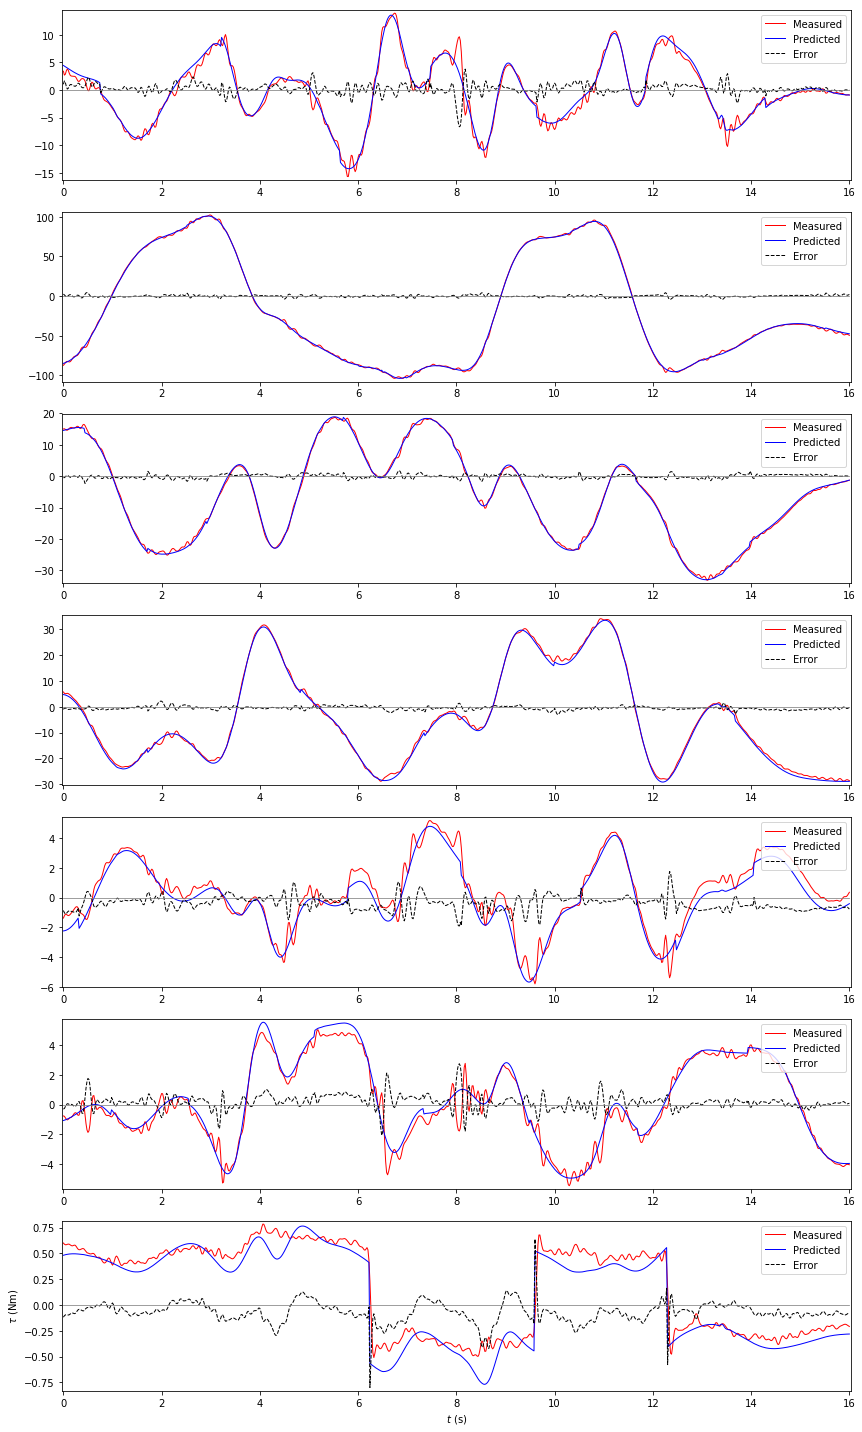

In [492]:
from support_funcs.regr_data_proc import  plot_meas_pred_tau

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12,20]

proc = numpy.load(tmpfolder + 'procdata/' + indentification_traj + '_proc.npz')
t = proc['t']
tau = proc['tau']

tau_p = np.zeros(tau.shape)
tau_ps = W.dot(beta_ols)
for i in range(dof):
    tau_p[:, i] = tau_ps[i::dof].flatten()

base_freq = 0.05    
trajectory_sampling_rate = 50
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)

save_fig_path = tmpfolder + '/solutions/fig/ols_result.png'
plot_meas_pred_tau(save_fig_path, t[:plot_data_num], tau[:plot_data_num, :],
                   tau_p[:plot_data_num, :])

## Method 2:Weighted Least Square (WLS)

In [493]:
proc = numpy.load(tmpfolder + 'procdata/' + indentification_traj + '_proc.npz')
t = proc['t']
tau = proc['tau']

weight = np.max(tau, axis=0) - np.min(tau, axis=0)
print("weight: ")
print(weight)


# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W.shape[0]/weight.shape[0])

weight: 
[ 29.56585096 205.95535244  51.88066664  62.98309543  10.96699859
  10.50483331   1.29465732]


In [494]:
weights[0:6]

array([0.0338228 , 0.00485542, 0.019275  , 0.01587728, 0.09118265,
       0.09519428])

In [495]:
W_wls = np.multiply(W, np.asmatrix(weights).transpose())
omega_wls = np.multiply(omega.T, weights).T
Q1_wls,R1_wls = numpy.linalg.qr(W_wls)
rho1_wls = Q1_wls.T*omega_wls

In [496]:
%time beta_wls = (R1_wls.T * R1_wls).I * R1_wls.T * rho1_wls

CPU times: user 4.66 ms, sys: 133 µs, total: 4.8 ms
Wall time: 929 µs


In [497]:
numpy.savetxt(tmpfolder + 'solutions/V1_' + indentification_traj + '_beta_wls.dat', beta_wls)

In [498]:
rho2_norm_sqr_wls = numpy.linalg.norm(omega_wls - W_wls * beta_wls)**2

### plot measured and predicted torque

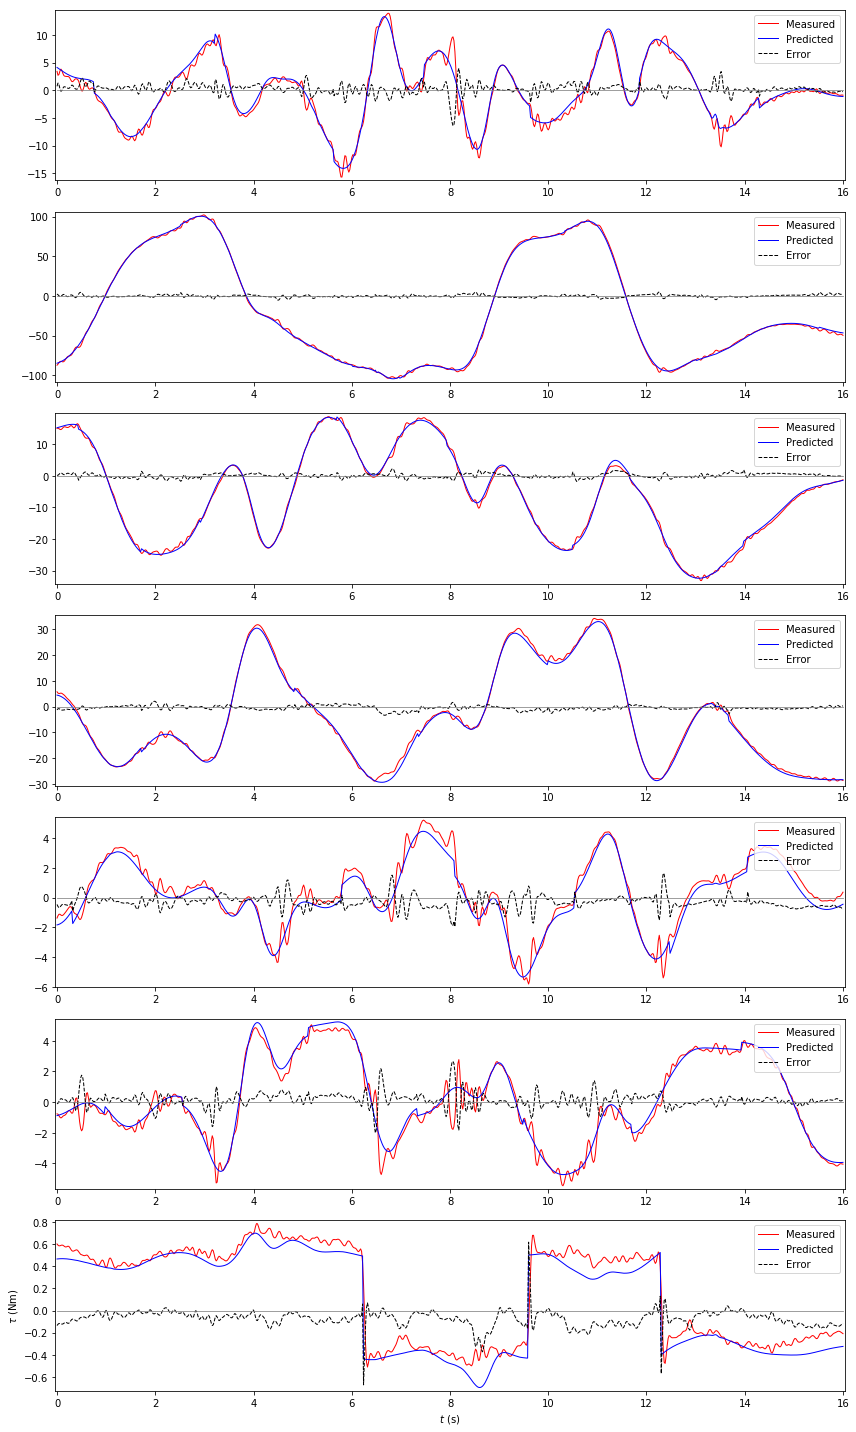

In [499]:
from support_funcs.regr_data_proc import  plot_meas_pred_tau

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12,20]

proc = numpy.load(tmpfolder + 'procdata/' + indentification_traj + '_proc.npz')
t = proc['t']
tau = proc['tau']

tau_p = np.zeros(tau.shape)
tau_ps = W.dot(beta_wls)
for i in range(dof):
    tau_p[:, i] = tau_ps[i::dof].flatten()

base_freq = 0.05    
trajectory_sampling_rate = 50
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
save_fig_path = tmpfolder + 'solutions/fig/wls_result.png'
plot_meas_pred_tau(save_fig_path, t[:plot_data_num], tau[:plot_data_num, :],
                   tau_p[:plot_data_num, :])

## Method 3:Feasible Base Parameter Estimation with Ordinary Least Squares (FBPE-OLS) 

In [500]:
u = sympy.Symbol('u')
U_beta = BlockMatrix([[Matrix([u]),            (beta_ols - beta_symbs).T],
                 [beta_ols - beta_symbs,                 I(n_beta)]])
U_beta = U_beta.as_explicit()

In [501]:
lmis_ols_fbpe = [LMI(U_beta)] + EB_LMIs_marg

In [502]:
lmis_ols_fbpe[1]

Matrix([
[L_1xx, L_1xy,                 L_1xz,     0,  l_1z, -l_1y],
[L_1xy, L_1yy,                 L_1yz, -l_1z,     0,  l_1x],
[L_1xz, L_1yz, -Ia_1 - L_2yy + beta1,  l_1y, -l_1x,     0],
[    0, -l_1z,                  l_1y,   m_1,     0,     0],
[ l_1z,     0,                 -l_1x,     0,   m_1,     0],
[-l_1y,  l_1x,                     0,     0,     0,   m_1]]) >= Matrix([
[1.0e-30,       0,       0,       0,       0,       0],
[      0, 1.0e-30,       0,       0,       0,       0],
[      0,       0, 1.0e-30,       0,       0,       0],
[      0,       0,       0, 1.0e-30,       0,       0],
[      0,       0,       0,       0, 1.0e-30,       0],
[      0,       0,       0,       0,       0, 1.0e-30]])

In [503]:
variables_ols_fbpe = [u] + list(beta_symbs) + list(delta_d)

In [504]:
objf_ols_fbpe = u

In [505]:
sol_ols_fbpe = solve_sdp(objf_ols_fbpe, lmis_ols_fbpe, variables_ols_fbpe)

sdp.dat-s -save dsdp5.out -gaptol 1e-07 

Variables 92 
Matrix Blocks: 29, Total Number of Constraints: 126 
Nonzeros in Constraints: 447

Read Data File into Buffer:      5.350e-04 seconds
DSDP Set Data:                   8.202e-05 seconds
DSDP Process Data:               1.401e-03 seconds

Data Norms: C: 1.40e+01, A: 1.91e+01, b: 1.00e+00
Scale C: 1.00e+00

Potential Parameter: 5.00
Reapply Schur matrix: 4

Iter   PP Objective      DD Objective    PInfeas   DInfeas     Nu     StepLength   Pnrm
---------------------------------------------------------------------------------------
0     1.00000000e+10   -2.80976734e+12   2.0e+00   2.8e+04   2.8e+12  0.00  0.00   0.00 
10    3.02266235e+14   -5.10763359e+13   9.1e+05   5.1e+05   3.0e+11  0.84  1.00   7.38 
20    8.29171108e+11   -2.47493454e+11   8.6e+03   2.5e+03   2.6e+09  1.00  1.00   0.87 
30    2.28771088e+10   -6.79387856e+09   2.6e+02   6.8e+01   7.4e+07  1.00  1.00   0.84 
40    7.99677799e+08   -1.21870705e+08   7.3e+00   1.1e

In [506]:
u_ols_fbpe= sol_ols_fbpe[0,0]

beta_ols_fbpe = sol_ols_fbpe[1:1+n_beta]
delta_d_ols_fbpe = sol_ols_fbpe[1+n_beta:]
delta_ols_fbpe = Pb*beta_ols_fbpe + (-Pb*rbt.dyn.Kd+rbt.dyn.Pd)*delta_d_ols_fbpe

In [507]:
u_ols_fbpe

0.6738238757041768

### plot measured and predicted torque

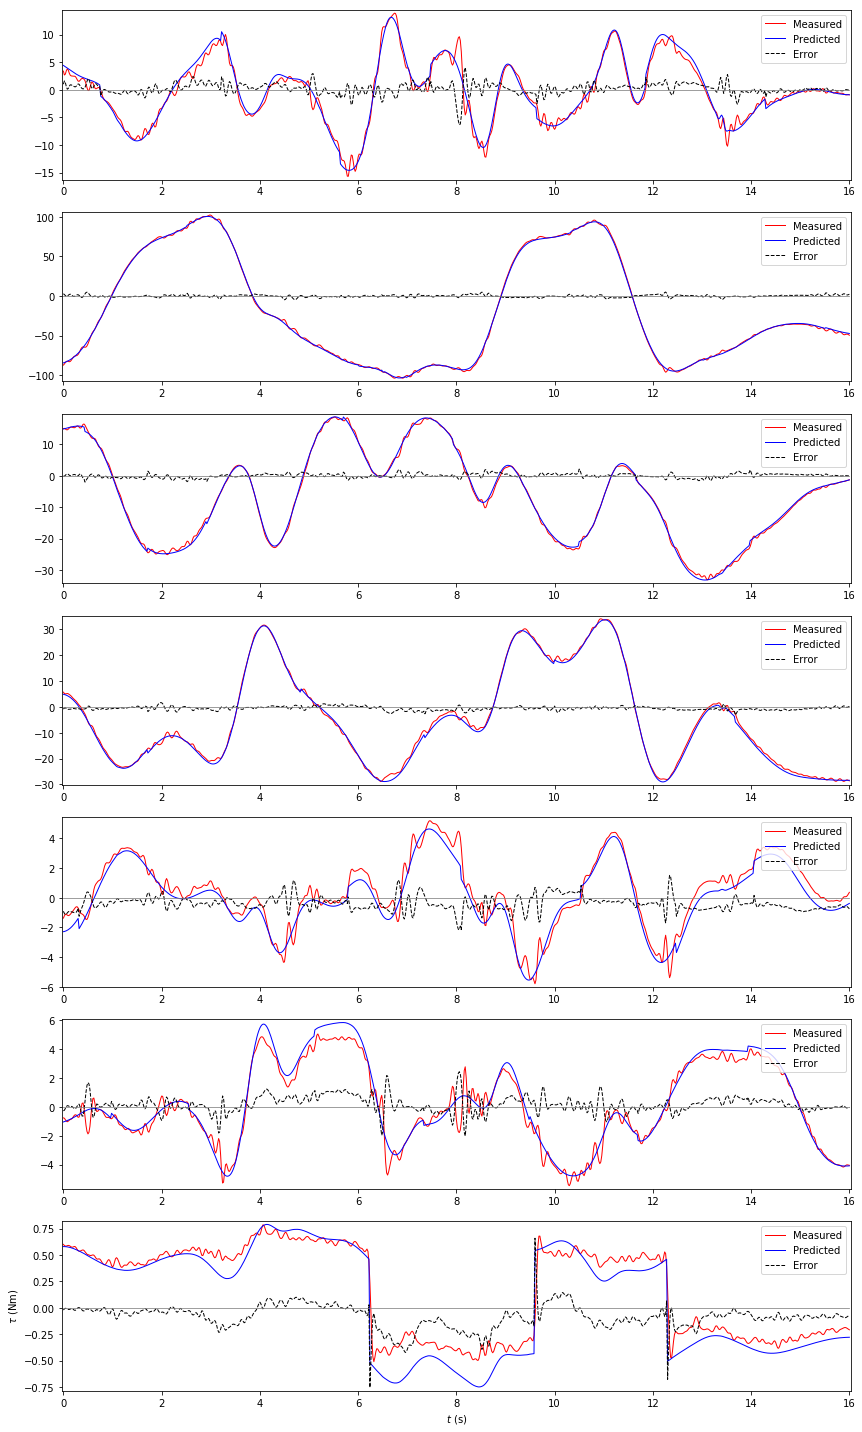

In [508]:
from support_funcs.regr_data_proc import  plot_meas_pred_tau

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12,20]

proc = numpy.load(tmpfolder + 'procdata/' + indentification_traj + '_proc.npz')
t = proc['t']
tau = proc['tau']

tau_p = np.zeros(tau.shape)
tau_ps = W.dot(beta_ols_fbpe)
for i in range(dof):
    tau_p[:, i] = tau_ps[i::dof].flatten()

base_freq = 0.05    
trajectory_sampling_rate = 50
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
save_fig_path = tmpfolder + 'solutions/fig/fbpe-ols_result.png'
plot_meas_pred_tau(save_fig_path, t[:plot_data_num], tau[:plot_data_num, :],
                   tau_p[:plot_data_num, :])

### Solution Double Check

In [509]:
dict_subs = dict(zip(beta_symbs, beta_ols_fbpe.flatten().tolist()[0]))
dict_subs.update(dict(zip(delta_d, delta_d_ols_fbpe.flatten().tolist()[0])))

test = 'ok'
for i, DBi in enumerate(EB_blocks):
        m = numpy.matrix(mrepl(DBi, dict_subs)).astype(float)
        for v in numpy.linalg.eigvals( m ):
            if v <= 0.0:
                print i, v
                test = 'fail'
print(test)

0 -2.0367909231475128e-10
fail


In [510]:
numpy.savetxt(tmpfolder + 'solutions/V1_' + indentification_traj + '_beta_ols_fbpe.dat', beta_ols_fbpe)
numpy.savetxt(tmpfolder + 'solutions/V1_' + indentification_traj + '_delta_ols_fbpe.dat', delta_ols_fbpe)

## Method 4:Feasible Base Parameter Estimation with Weight Least Squares (FBPE-WLS)     

In [511]:
u = sympy.Symbol('u')
U_rho = BlockMatrix([[Matrix([u - rho2_norm_sqr_wls]), (rho1_wls - R1_wls*beta_symbs).T],
                     [rho1_wls - R1_wls*beta_symbs,                       I(n_beta)]])
U_rho = U_rho.as_explicit()

In [512]:
lmis_fbpe_wls = [LMI(U_rho)] + EB_LMIs_marg

In [513]:
variables_fbpe_wls = [u] + list(beta_symbs) + list(delta_d)

In [514]:
objf_fbpe_wls = u

In [515]:
sol_fbpe_wls = solve_sdp(objf_fbpe_wls, lmis_fbpe_wls, variables_fbpe_wls)

sdp.dat-s -save dsdp5.out -gaptol 1e-07 

Variables 92 
Matrix Blocks: 29, Total Number of Constraints: 126 
Nonzeros in Constraints: 2219

Read Data File into Buffer:      3.323e-03 seconds
DSDP Set Data:                   8.988e-05 seconds
DSDP Process Data:               1.316e-02 seconds

Data Norms: C: 3.24e+01, A: 3.56e+02, b: 1.00e+00
Scale C: 1.00e+00

Potential Parameter: 5.00
Reapply Schur matrix: 4

Iter   PP Objective      DD Objective    PInfeas   DInfeas     Nu     StepLength   Pnrm
---------------------------------------------------------------------------------------
0     1.00000000e+10   -1.01822901e+13   2.0e+00   1.0e+05   1.0e+13  0.00  0.00   0.00 
10    5.13023293e+14   -8.40655173e+13   9.0e+05   8.4e+05   7.8e+11  0.62  1.00   0.64 
20    4.08050046e+11   -1.11856939e+11   3.9e+03   1.1e+03   1.2e+09  1.00  1.00   1.06 
30    8.82951029e+09   -2.54180826e+09   9.6e+01   2.5e+01   2.8e+07  1.00  1.00   0.85 
40    3.18767271e+08   -9.27750104e+06   1.9e+00   0.0

In [516]:
u_wls_fbpe = sol_fbpe_wls[0,0]
beta_wls_fbpe = numpy.matrix(sol_fbpe_wls[1:1+n_beta])
delta_d_wls_fbpe = numpy.matrix(sol_fbpe_wls[1+n_beta:])
delta_wls_fbpe = Pb*beta_wls_fbpe + (-Pb*rbt.dyn.Kd+rbt.dyn.Pd)*delta_d_wls_fbpe

In [517]:
u_wls_fbpe

10.84139996646721

### plot measured and predicted torque

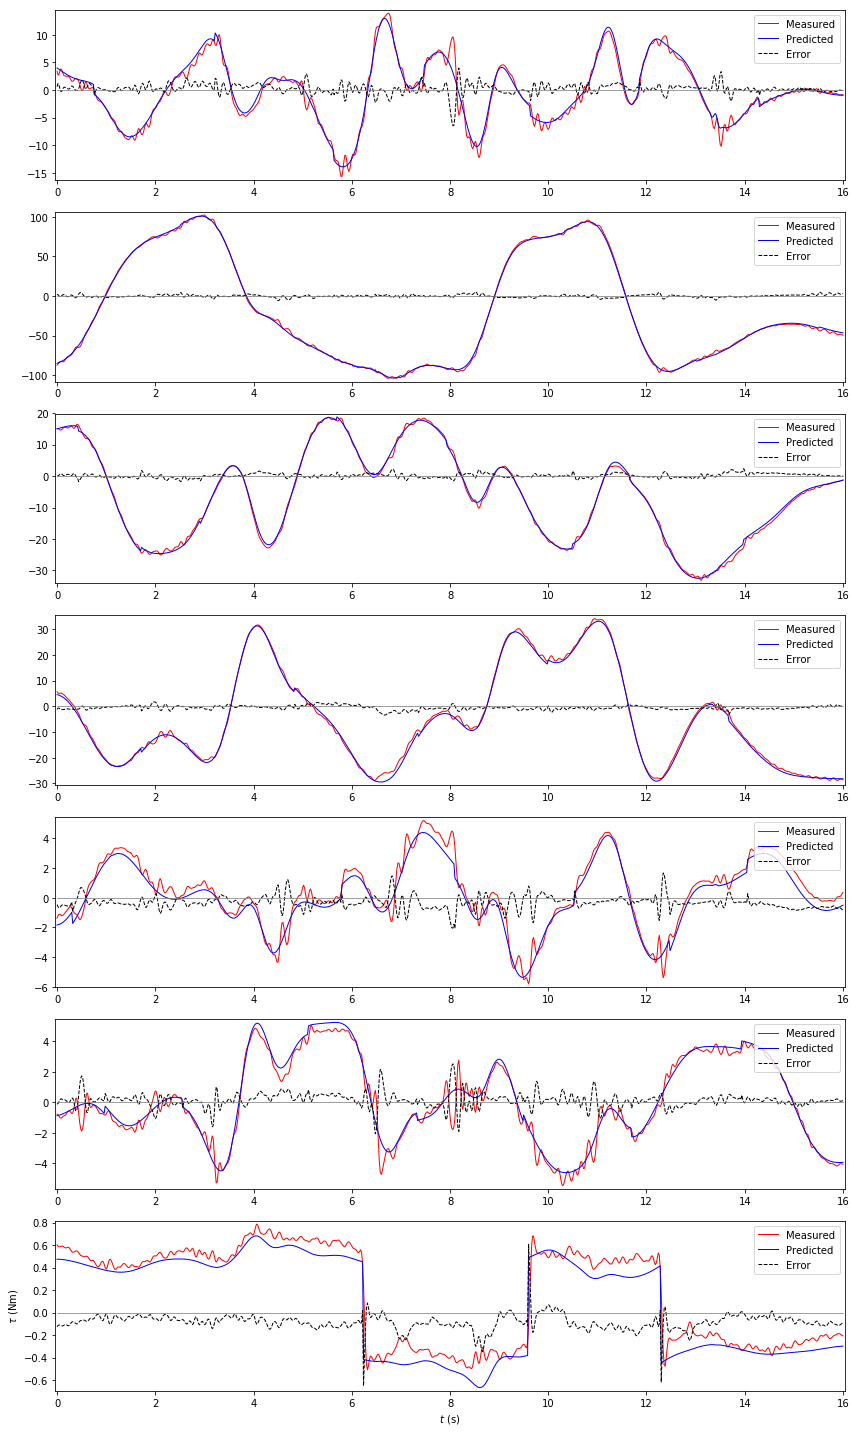

In [518]:
from support_funcs.regr_data_proc import  plot_meas_pred_tau

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12,20]

proc = numpy.load(tmpfolder + 'procdata/' + indentification_traj + '_proc.npz')
t = proc['t']
tau = proc['tau']

tau_p = np.zeros(tau.shape)
tau_ps = W.dot(beta_wls_fbpe)
for i in range(dof):
    tau_p[:, i] = tau_ps[i::dof].flatten()

base_freq = 0.05    
trajectory_sampling_rate = 50
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
save_fig_path = tmpfolder + 'solutions/fig/fbpe-wls_result.png'
plot_meas_pred_tau(save_fig_path, t[:plot_data_num], tau[:plot_data_num, :],
                   tau_p[:plot_data_num, :])

### Solution Double Check

In [519]:
dict_subs = dict(zip(beta_symbs, beta_wls_fbpe.flatten().tolist()[0]))
dict_subs.update(dict(zip(delta_d, delta_d_wls_fbpe.flatten().tolist()[0])))

test = 'ok'
for EBi in EB_blocks:
        m = numpy.matrix(mrepl(EBi, dict_subs)).astype(float)
        for v in numpy.linalg.eigvals( m ):
            if v <= 0.0:
                print(v)
                test = 'fail'
print(test)

ok


In [520]:
numpy.savetxt(tmpfolder + 'solutions/V1_' + indentification_traj + '_beta_wls_fbpe.dat', beta_wls_fbpe)
numpy.savetxt(tmpfolder + 'solutions/V1_' + indentification_traj + '_delta_wls_fbpe.dat', delta_wls_fbpe)

## Method 5:Additional Constraints on Centers-of-Mass

In [521]:
# import sympy as sp
# link_cuboid_hulls = [
# [[ +0.000005 , +0.000006 ],[ -0.04 , -0.03 ],[ -0.07 , -0.06 ]],
# [[ -0.000005 , -0.000004 ],[ 0.09 , 0.10 ],[ +0.03 , +0.04 ]],
# [[ +0.0000009 , +0.000001 ],[ -0.03 , -0.02 ],[ -0.06 , -0.05 ]],
# [[ -0.000004 , -0.000003 ],[ +0.07 , +0.08 ],[ +0.03 , +0.04 ]],
# [[ +0.000009 , +0.000010 ],[ -0.03 , -0.02 ],[ -0.07 , -0.06 ]],
# [[ -0.000011 , -0.00010 ],[ +0.09 , +0.10 ],[ +0.01 , +0.02 ]],
# [[ +0.00003 , +0.00004 ],[ +0.02 , +0.03 ],[ -0.05 , -0.04 ]],
# ]


# link_cuboid_hulls = [
# [[ -0.140 , +0.140 ],[ -0.174 , +0.174 ],[ -0.084 , +0.346 ]],
# [[ -0.084 , +0.084 ],[ -0.174 , +0.174 ],[ -0.084 , +0.170 ]],
# [[ -0.090 , +0.040 ],[ -0.550 , +0.040 ],[ -0.045 , +0.045 ]],
# [[ -0.045 , +0.095 ],[ -0.045 , +0.045 ],[ -0.050 , +0.830 ]],
# [[ -0.045 , +0.045 ],[ -0.020 , +0.100 ],[ -0.045 , +0.045 ]],
# [[ -0.045 , +0.045 ],[ -0.060 , +0.045 ],[ -0.020 , +0.060 ]],
# [[ -0.045 , +0.045 ],[ -0.045 , +0.045 ],[ -0.018 , +0.001 ]],
# ]


robotmaxmass = 22

#### LMI Matrix Definition

In [522]:
D_add_blocks = []
# for i in range(rbt.dof):
#     l = rbt.rbtdef.l[i]
#     m = rbt.rbtdef.m[i]
#     link_cuboid_hull = link_cuboid_hulls[i]
#     for j in range(3):
#         D_add_blocks.append( Matrix( [[  l[j] - m*link_cuboid_hull[j][0] ]] ) )
#         D_add_blocks.append( Matrix( [[ -l[j] + m*link_cuboid_hull[j][1] ]] ) )
        
D_add_blocks.append( Matrix( [[ rbt.rbtdef.m[0] - 5.4 ]] ) )
D_add_blocks.append( Matrix( [[ -rbt.rbtdef.m[0] + 5.5 ]] ) )
D_add_blocks.append( Matrix( [[ rbt.rbtdef.m[1] - 4.6 ]] ) )
D_add_blocks.append( Matrix( [[ -rbt.rbtdef.m[1] + 4.7 ]] ) )
D_add_blocks.append( Matrix( [[ rbt.rbtdef.m[2] - 2.6 ]] ) )
D_add_blocks.append( Matrix( [[ -rbt.rbtdef.m[2] + 2.7 ]] ) )
D_add_blocks.append( Matrix( [[ rbt.rbtdef.m[3] - 2.6 ]] ) )
D_add_blocks.append( Matrix( [[ -rbt.rbtdef.m[3] + 2.7 ]] ) )
D_add_blocks.append( Matrix( [[ rbt.rbtdef.m[4] - 2.5 ]] ) )
D_add_blocks.append( Matrix( [[ -rbt.rbtdef.m[4] + 2.6 ]] ) )
D_add_blocks.append( Matrix( [[ rbt.rbtdef.m[5] - 1.9 ]] ) )
D_add_blocks.append( Matrix( [[ -rbt.rbtdef.m[5] + 2.0 ]] ) )
D_add_blocks.append( Matrix( [[ rbt.rbtdef.m[6] - 0.8 ]] ) )
D_add_blocks.append( Matrix( [[ -rbt.rbtdef.m[6] + 0.9 ]] ) )

# D_add_blocks.append(Matrix([robotmaxmass - sum(rbt.rbtdef.m)]))

#### Variable Change and LMI Definition

In [523]:
DB_add_blocks = [ mrepl(Di, varchange_dict) for Di in D_add_blocks ]

In [524]:
DB_add_LMIs = list(map(LMI_PD, DB_add_blocks))

In [525]:
DB_add_LMIs_marg = list(map(lambda lm: LMI(lm, epsilon_safemargin*eye(lm.shape[0])) , DB_add_blocks))

In [526]:
DB_add_LMIs_marg[0]

Matrix([[m_1 - 5.4]]) >= Matrix([[1.0e-30]])

In [527]:
DB_add_LMIs_marg[-1]

Matrix([[-m_7 + 0.9]]) >= Matrix([[1.0e-30]])

### Testing $\beta^\star$ solution on new constraints

In [528]:
dict_subs = dict(zip(beta_symbs, beta_wls_fbpe.flatten().tolist()[0]))
lmis_star_bpft_add = [ lmi_sdp.LMI_PD(mrepl(lmi.canonical().gts, dict_subs)) for lmi in DB_add_LMIs_marg ]
variables_star_bpft_add = list(delta_d)
objf_star_bpft_add = delta_d[0]

In [529]:
sol_star_bpft_add = solve_sdp(objf_star_bpft_add, lmis_star_bpft_add, variables_star_bpft_add)

sdp.dat-s -save dsdp5.out -gaptol 1e-07 

Variables 29 
Matrix Blocks: 14, Total Number of Constraints: 14 
Nonzeros in Constraints: 28

Read Data File into Buffer:      6.914e-05 seconds
DSDP Set Data:                   3.290e-05 seconds
Trying Sparse M: Total nonzeros: 0 of 406 
DSDP Process Data:               6.509e-05 seconds

Data Norms: C: 1.24e+01, A: 3.74e+00, b: 1.00e+00
Scale C: 3.13e-01

Potential Parameter: 5.00
Reapply Schur matrix: 10

Iter   PP Objective      DD Objective    PInfeas   DInfeas     Nu     StepLength   Pnrm
---------------------------------------------------------------------------------------
0     1.00000000e+10   -1.71990835e+12   2.0e+00   1.7e+04   1.7e+12  0.00  0.00   0.00 
10    1.00000017e+07    1.00000000e+07   1.0e+00   0.0e+00   4.9e-03  1.00  0.24   4.03 
11    1.00000003e+07    1.00000000e+07   1.0e+00   0.0e+00   9.6e-04  1.00  1.00   0.27 
DSDP Converged. 
DSDP Dual Unbounded, Primal Infeasible

P Objective  :   6.80524268e-02 
DSDP Solutio

### Finding new solution

In [530]:
lmis_fbpe_ols_add = [LMI(U_rho)] + EB_LMIs_marg + DB_add_LMIs_marg

In [531]:
variables_fbpe_ols_add = [u] + list(beta_symbs) + list(delta_d)

In [532]:
objf_fbpe_ols_add = u

In [533]:
sol_fbpe_ols_add = solve_sdp(objf_fbpe_ols_add, lmis_fbpe_ols_add, variables_fbpe_ols_add)

sdp.dat-s -save dsdp5.out -gaptol 1e-07 

Variables 92 
Matrix Blocks: 43, Total Number of Constraints: 140 
Nonzeros in Constraints: 2247

Read Data File into Buffer:      3.370e-03 seconds
DSDP Set Data:                   1.040e-04 seconds
DSDP Process Data:               1.311e-02 seconds

Data Norms: C: 3.47e+01, A: 3.56e+02, b: 1.00e+00
Scale C: 1.00e+00

Potential Parameter: 5.00
Reapply Schur matrix: 4

Iter   PP Objective      DD Objective    PInfeas   DInfeas     Nu     StepLength   Pnrm
---------------------------------------------------------------------------------------
0     1.00000000e+10   -9.30918589e+12   2.0e+00   9.3e+04   9.3e+12  0.00  0.00   0.00 
10    7.99780641e+13   -2.35269428e+13   2.6e+05   2.4e+05   1.8e+11  1.00  1.00   1.53 
20    7.01659589e+10   -2.44754141e+10   6.2e+02   2.4e+02   2.0e+08  1.00  1.00   1.19 
30    6.98553782e+08   -1.35537117e+08   5.1e+00   1.3e+00   1.9e+06  1.00  1.00   0.98 
40    4.08983518e+06   -2.45237558e+05   2.4e-03   0.0

In [534]:
u_starextra = sol_fbpe_ols_add[0,0]
beta_starextra = numpy.matrix(sol_fbpe_ols_add[1:1+n_beta])
delta_d_starextra = numpy.matrix(sol_fbpe_ols_add[1+n_beta:])
delta_starextra = Pb*beta_starextra + (-Pb*rbt.dyn.Kd+rbt.dyn.Pd)*delta_d_starextra

In [535]:
u_starextra

11.05869689008596

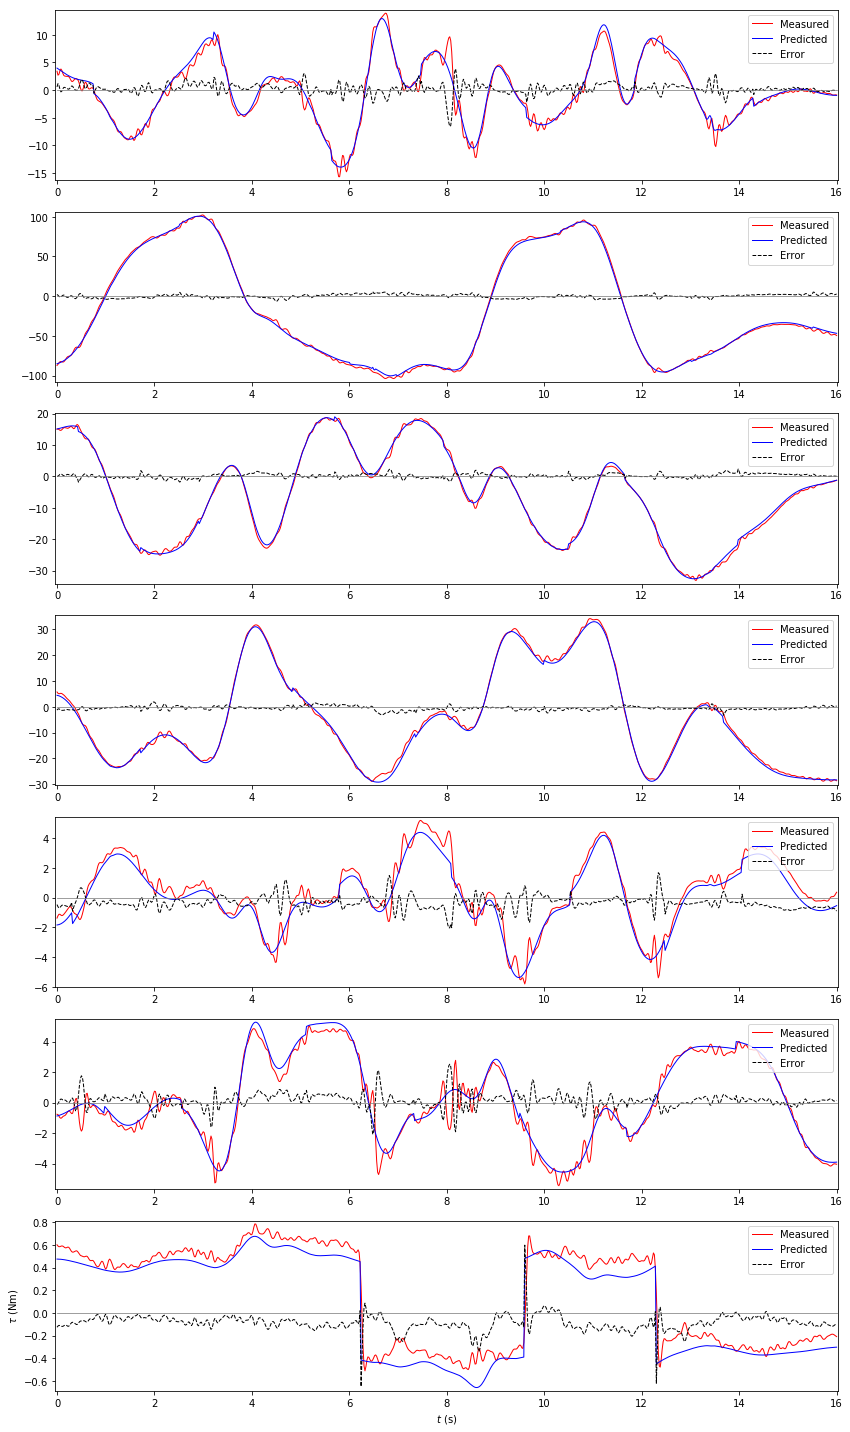

In [536]:
from support_funcs.regr_data_proc import  plot_meas_pred_tau

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12,20]

proc = numpy.load(tmpfolder + 'procdata/' + indentification_traj + '_proc.npz')
t = proc['t']
tau = proc['tau']

tau_p = np.zeros(tau.shape)
tau_ps = W.dot(beta_starextra)
for i in range(dof):
    tau_p[:, i] = tau_ps[i::dof].flatten()

base_freq = 0.05    
trajectory_sampling_rate = 50
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
save_fig_path = tmpfolder + 'solutions/fig/starextra_result.png'
plot_meas_pred_tau(save_fig_path, t[:plot_data_num], tau[:plot_data_num, :],
                   tau_p[:plot_data_num, :])

### Solution Double Check

In [537]:
dict_subs = dict(zip(beta_symbs, beta_starextra.flatten().tolist()[0]))
dict_subs.update(dict(zip(delta_d, delta_d_starextra.flatten().tolist()[0])))

test = 'ok'
for DBi in (EB_blocks + DB_add_blocks):
        m = numpy.matrix(mrepl(DBi, dict_subs)).astype(float)
        for v in numpy.linalg.eigvals( m ):
            if v <= 0.0: test = 'fail'
print(test)

ok


In [538]:
numpy.savetxt(tmpfolder + 'solutions/V1_' + indentification_traj + '_beta_starextra.dat', beta_starextra)
numpy.savetxt(tmpfolder + 'solutions/V1_' + indentification_traj + '_delta_starextra.dat', delta_starextra)

### Inertia Matrix Definiteness Tests

In [539]:
def test_mass_matrix_psd(beta_solution):
    K = rbt.dyn.Pb.T + rbt.dyn.Kd * rbt.dyn.Pd.T
    A = numpy.matrix(K).astype(float)
    b = numpy.matrix(beta_solution).astype(float)
    x = numpy.linalg.pinv(A) * b
    d_test = x
    
    M_func_def = sympybotics.robotcodegen.robot_code_to_func( 'python', rbt.M_code, 'M', 'M_func', rbt.rbtdef)
    exec(M_func_def, globals())
    global sin, cos
    from math import sin, cos
    
    ntests = 10000
    
    ok = 0
    nok = 0
    for i in range(ntests):
        q_test = numpy.random.rand(rbt.dof)
        M_out = M_func( numpy.array(d_test).flatten().tolist(), q_test)
        M = numpy.matrix(M_out).reshape((rbt.dof,rbt.dof))
        try:
            c = numpy.linalg.cholesky(M)
        except:
            nok += 1
            continue
        ok += 1
        
    print 'ok     %8i  %3i%%'%(ok, 100.0*ok/ntests) 
    print 'not ok %8i  %3i%%'%(nok, 100.0*nok/ntests)
    if nok > 0 :
        print('\nNot PSD -> Not feasible!')
    else:
        print('\nSeems feasible.')

In [540]:
beta_ols = numpy.matrix(numpy.loadtxt(tmpfolder + 'solutions/V1_traj1_beta_ols.dat')).T
test_mass_matrix_psd(beta_ols)

ok            0    0%
not ok    10000  100%

Not PSD -> Not feasible!


In [541]:
beta_wls = numpy.matrix(numpy.loadtxt(tmpfolder + 'solutions/V1_traj1_beta_wls.dat')).T
test_mass_matrix_psd(beta_wls)

ok            0    0%
not ok    10000  100%

Not PSD -> Not feasible!


In [542]:
beta_ols_fbpe = numpy.matrix(numpy.loadtxt(tmpfolder + 'solutions/V1_traj1_beta_ols_fbpe.dat')).T
test_mass_matrix_psd(beta_ols_fbpe)

ok        10000  100%
not ok        0    0%

Seems feasible.


In [543]:
beta_wls_fbpe = numpy.matrix(numpy.loadtxt(tmpfolder + 'solutions/V1_traj1_beta_wls_fbpe.dat')).T
test_mass_matrix_psd(beta_wls_fbpe)

ok        10000  100%
not ok        0    0%

Seems feasible.


In [544]:
beta_starextra = numpy.matrix(numpy.loadtxt(tmpfolder + 'solutions/V1_traj1_beta_starextra.dat')).T
test_mass_matrix_psd(beta_starextra)

ok        10000  100%
not ok        0    0%

Seems feasible.


In [545]:
from support_funcs.utils import ListTable

form = '%.4g'

import sympy

table = ListTable()
header = ['', 'beta_cad', 'beta_ols', 'beta_wls', 'beta_ols_fbpe','beta_wls_fbpe','beta_starextra']
table.append(header)
for i, b in enumerate(rbt.dyn.baseparms.n()):
    cad_v = '---'
    row = ['%.7s ...'%b if len(str(b)) > 107 else str(b), cad_v]
#     row += [form%solutions_beta['beta_ols'][i,0], '%.2g'%analysis['id']['betas']['beta_ols']['sd%'][i,0]]
    row += [form%beta_ols[i,0]]
    row += [form%beta_wls[i,0]]
    row += [form%beta_ols_fbpe[i,0]]
    row += [form%beta_wls_fbpe[i,0]]
    row += [form%beta_starextra[i,0]]
    table.append(row)
table

,beta_cad,beta_ols,beta_wls,beta_ols_fbpe,beta_wls_fbpe,beta_starextra
Ia_1 + L_1zz + L_2yy,---,-0.1904,-0.199,0.1116,0.07226,0.04333
fv_1,---,-0.276,-0.2814,3.18e-10,1.907e-08,2.093e-08
fc_1,---,0.9491,0.9791,0.9491,0.863,0.8263
L_2xx - ...,---,2.463,2.49,2.465,2.227,2.48
L_2xy,---,0.2044,0.3324,0.1477,0.1864,0.08101
L_2xz,---,0.02647,0.01659,0.04976,0.04873,0.05343
L_2yz,---,0.4835,0.2517,0.2379,0.111,0.1512
Ia_2 + ...,---,1.753,1.708,1.803,2.315,4.492
l_2x,---,0.00746,-0.04708,0.00746,-0.002691,0.17
l_2y - l_3z - 0.4375*m_3 - 0.4375*m_4 - 0.4375*m_5 - 0.4375*m_6 - 0.4375*m_7,---,-6.61,-6.642,-6.61,-6.581,-6.227


In [546]:
delta_ols_fpe = numpy.matrix(numpy.loadtxt(tmpfolder + 'solutions/V1_traj1_delta_ols_fbpe.dat')).T
delta_wls_fpe = numpy.matrix(numpy.loadtxt(tmpfolder + 'solutions/V1_traj1_delta_wls_fbpe.dat')).T
delta_starextra = numpy.matrix(numpy.loadtxt(tmpfolder + 'solutions/V1_traj1_delta_starextra.dat')).T
form = '%.6g'

table = ListTable()
header = ['', 'Dcad', 'delta_ols_fpe', 'delta_wls_fpe', 'delta_starextra']
table.append(header)
for i, d in enumerate(rbt.dyn.dynparms):
    cad_v = '---'
    row = ['%.7s ...'%b if len(str(d)) > 7 else str(d), cad_v]
    row += [form%delta_ols_fpe[i,0]]
    row += [form%delta_wls_fpe[i,0]]
    row += [form%delta_starextra[i,0]]
    table.append(row)
table

,Dcad,delta_ols_fpe,delta_wls_fpe,delta_starextra
L_1xx,---,5.7735e+06,5.7735e+06,5.7735e+06
L_1xy,---,-1.40876e-11,1.32635e-11,7.79903e-12
L_1xz,---,-2.68122e-09,1.9133e-09,-4.26899e-10
L_1yy,---,5.7735e+06,5.7735e+06,5.7735e+06
L_1yz,---,-2.68122e-09,1.9133e-09,-4.26899e-10
L_1zz,---,2.90686e-10,5.69497e-09,3.13269e-09
l_1x,---,-2.27882e-09,-2.12218e-09,2.65679e-15
l_1y,---,2.27882e-09,2.12218e-09,-2.65679e-15
l_1z,---,-1.17305e-11,1.85654e-11,-4.15024e-11
m_1,---,7.74597e+06,7.74597e+06,5.45069


5 - Regression Model Validation
====================================================

In [547]:
import numpy as np
import sympybotics
import pickle

from collections import OrderedDict
from support_funcs.utils import ListTable

In [548]:
with open(tmpfolder +  'robotmodels/xMate7p.pkl', 'rb' ) as file:
          rbt = pickle.load( file )

In [549]:
def analyse(W, omega, R1, beta):
    from numpy import matrix, mean
    from numpy.linalg import cond, norm
    
    p = dict()
    
    n = W.shape[0]
    
    omega_norm = norm(omega)
    omega_mean = mean(omega)
    
    p['err'] = norm(omega - W * beta)
    p['merr'] = p['err'] / n
    
    p['se'] = p['err']**2
    p['mse'] = p['se']/(n-W.shape[1])
    p['rmse'] = p['mse']**0.5
    
    C = p['mse'] * (R1.T * R1).I
    p['sd'] = np.sqrt(C.diagonal()).T
    p['sd%'] = 100. * p['sd'] / np.abs(beta)
    
    p['relerr'] = p['err']/ omega_norm
    p['relerr%'] = p['relerr']*100.
    
    p['1-r2'] = p['err']**2 / norm(omega - omega_mean)**2
    p['r2'] = 1 - p['1-r2']

    return p
    

In [550]:
# trajs = OrderedDict([('id', 'traj1'),
#                      ('vA', 'traj2'),
#                      ('vB', 'traj3'),
#                      ('vC', 'traj4')])

trajs = OrderedDict([('id', 'traj1'),
                     ('vA', 'traj2'),
                     ('vB', 'traj3')])

betas = OrderedDict([('beta_ols', 'B^'),
                     ('beta_wls', 'B~'),
                     ('beta_ols_fbpe', 'B\''),
                     ('beta_wls_fbpe', 'B*'),
                     ('beta_starextra', 'B*e')])

In [551]:
solutions_beta = {betaname:np.matrix(np.loadtxt(tmpfolder + 'solutions/V1_%s_%s.dat'%(trajs['id'], betaname))).T for betaname in betas}

In [552]:
analysis = dict()

for traj in trajs:
    from numpy.linalg import cond
    
    analysis[traj] = dict()
    
    regr_mats = np.load(tmpfolder + 'procdata/' + trajs[traj] + '_regr.npz')
    W = np.matrix(regr_mats['W'])
    omega = np.matrix(regr_mats['omega'])
    R1 = np.matrix(regr_mats['R1'])
    
    analysis[traj]['cond'] = cond(W)
    
    analysis[traj]['betas'] = dict()
    
    for betaname in betas:
        beta = solutions_beta[betaname]
        analysis[traj]['betas'][betaname] = analyse(W, omega, R1, beta)
    
    del W, omega, R1

In [553]:
prop = lambda x: x['relerr%']
form = '%.2f'

table = ListTable()
table.append([''] + ['cond'] + betas.values())
for (traj, trajname) in zip(trajs, ['identification', 'validation A', 'validation B']):
    row = [traj] + ['%.0f'%analysis[traj]['cond']] + [ form%prop(analysis[traj]['betas'][b]) for b in betas]
    table.append(row)
table

,cond,B^,B~,B',B*,B*e
id,60,2.80,3.09,3.05,3.15,3.79
vA,86,3.04,3.38,3.34,3.44,4.16
vB,86,3.84,3.88,3.59,3.49,3.93


## Torque Plot

In [554]:
traj = 'vB'
betaname = 'beta_starextra'

In [555]:
regr_mats = np.load(tmpfolder + 'procdata/' + trajs[traj] + '_regr.npz')
W = np.matrix(regr_mats['W'])
omega = np.matrix(regr_mats['omega'])

regr_mats = np.load(tmpfolder + 'procdata/' + trajs[traj] + '_proc.npz')
t = regr_mats['t']
tau_proc = np.matrix(regr_mats['tau'])

regr_mats = np.load(tmpfolder + 'procdata/' + trajs[traj] + '_raw.npz')
tau_raw = np.matrix(regr_mats['tau'])

In [556]:
beta_solution = np.matrix(np.loadtxt(tmpfolder + 'solutions/V1_%s_%s.dat'%(trajs['id'], betaname))).T

In [557]:
tau = tau_raw

In [558]:
omega_pred = W * beta_solution
tau_pred = omega_pred.reshape( omega_pred.shape[0]/tau.shape[1], tau.shape[1] )
err_pred = tau - tau_pred      # 未滤波

err_pred_proc = tau_proc - tau_pred

RMS = []
for i in range(rbt.dof):
#     RMS.append(sqrt(err_pred_proc[:,i].T * err_pred_proc[:,i]/err_pred_proc.shape[0]))
#     RMS.append(sqrt(err_pred_proc[:,i].T * err_pred_proc[:,i]/err_pred_proc.shape[0]).tolist()[0][0])
    
    print("joint {} RMS: {}".format(i, sqrt(err_pred_proc[:,i].T * err_pred_proc[:,i]/err_pred_proc.shape[0]).tolist()[0][0]))
# print(RMS)

joint 0 RMS: 0.988678820426
joint 1 RMS: 2.27070553127
joint 2 RMS: 0.623151289334
joint 3 RMS: 0.99864850565
joint 4 RMS: 0.673145475003
joint 5 RMS: 0.346511952422
joint 6 RMS: 0.149823978135


In [559]:
joint = 7
firsts = 60000
s=tau_raw.shape[0]

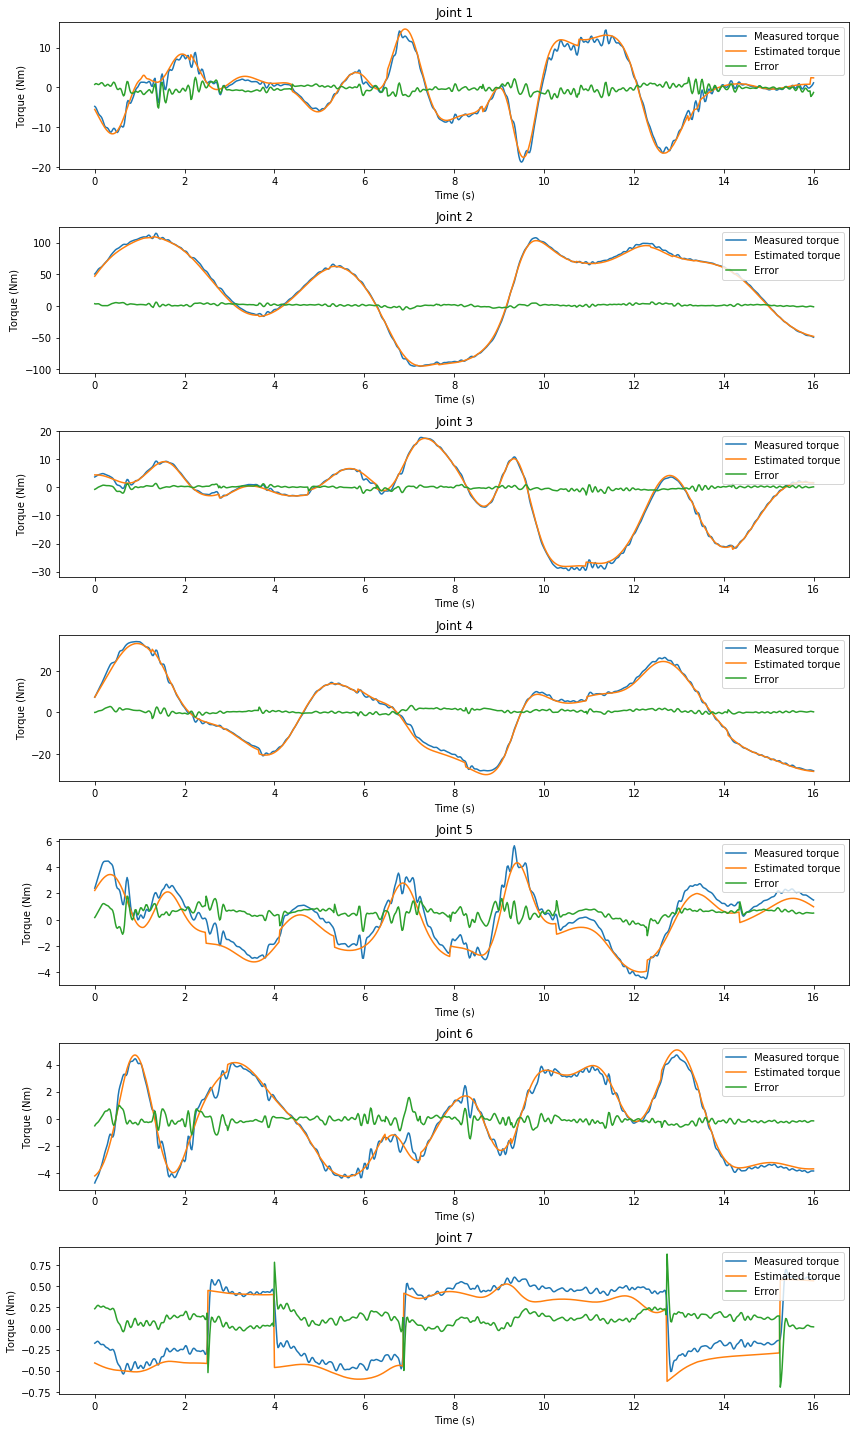

In [565]:
from matplotlib import pyplot as plt
plt.close()

plt.figure(figsize=(12,20))  
axes = []
for i in range(tau.shape[1]):
    ax = plt.subplot(7, 1, i+1)
#     ax.plot(t[:firsts],tau_raw[:,i][:firsts], label="Measured torque")
    ax.plot(t[:firsts],tau_proc[:,i][:firsts], label="Measured torque")
    ax.plot(t[:firsts],tau_pred[:,i][:firsts], label="Estimated torque")
    ax.plot(t[:firsts],err_pred_proc[:,i][:firsts], label="Error")
    ax.legend(loc='upper right',fontsize=10)
    ax.set_title( "Joint %d"%(i+1) )
    plt.xlabel("Time (s)")
    plt.ylabel("Torque (Nm)")
    axes.append(ax)

plt.tight_layout()
save_fig_path = tmpfolder + 'solutions/fig/' + traj + '_valid_result.png'
plt.savefig(save_fig_path)
plt.show()

In [566]:
delta_starextra = Pb*beta_starextra + (-Pb*rbt.dyn.Kd+rbt.dyn.Pd)*delta_d_starextra

$$\beta^\star = K\ \delta^\star$$
$$\delta^\star_{min} = pinv(K)\ \beta^\star$$
$$K\ \delta^\star_{min} == K\ \delta^\star$$

In [567]:
beta_data = numpy.matrix(numpy.loadtxt(tmpfolder + 'solutions/V1_traj1_beta_starextra.dat')).T
delta_data = numpy.matrix(numpy.loadtxt(tmpfolder + 'solutions/V1_traj1_delta_starextra.dat')).T

K = np.matrix(Pb.T+rbt.dyn.Kd*rbt.dyn.Pd.T).astype(float)
delta_data_min = np.linalg.pinv(K)*beta_data
numpy.savetxt(tmpfolder + 'solutions/V1_' + indentification_traj + '_delta_data_min.dat', delta_data_min)

# delta_data_min = numpy.matrix(numpy.loadtxt(tmpfolder + 'solutions/V1_traj1_delta_starextra.dat')).T

In [568]:
np.testing.assert_array_almost_equal(K * delta_starextra ,beta_starextra, 10)

## Change Parameters set order to Matlab version

In [569]:
parms = [0]*rbt.dyn.n_dynparms
for i in range(rbt.dof):
    parms[i*13] = delta_data.tolist()[i*13+9]
    parms[i*13+1] = delta_data.tolist()[i*13+6]
    parms[i*13+2] = delta_data.tolist()[i*13+7]
    parms[i*13+3] = delta_data.tolist()[i*13+8]
    parms[i*13+4] = delta_data.tolist()[i*13]
    parms[i*13+5] = delta_data.tolist()[i*13+3]
    parms[i*13+6] = delta_data.tolist()[i*13+5]
    parms[i*13+7] = delta_data.tolist()[i*13+1]
    parms[i*13+8] = delta_data.tolist()[i*13+2]
    parms[i*13+9] = delta_data.tolist()[i*13+4]
    parms[i*13+10] = delta_data.tolist()[i*13+10]
    parms[i*13+11] = delta_data.tolist()[i*13+11]
    parms[i*13+12] = delta_data.tolist()[i*13+12]


# for i in range(rbt.dof):
#     parms[i*13] = delta_data_min.tolist()[i*13+9]
#     parms[i*13+1] = delta_data_min.tolist()[i*13+6]
#     parms[i*13+2] = delta_data_min.tolist()[i*13+7]
#     parms[i*13+3] = delta_data_min.tolist()[i*13+8]
#     parms[i*13+4] = delta_data_min.tolist()[i*13]
#     parms[i*13+5] = delta_data_min.tolist()[i*13+3]
#     parms[i*13+6] = delta_data_min.tolist()[i*13+5]
#     parms[i*13+7] = delta_data_min.tolist()[i*13+1]
#     parms[i*13+8] = delta_data_min.tolist()[i*13+2]
#     parms[i*13+9] = delta_data_min.tolist()[i*13+4]
#     parms[i*13+10] = delta_data_min.tolist()[i*13+10]
#     parms[i*13+11] = delta_data_min.tolist()[i*13+11]
#     parms[i*13+12] = delta_data_min.tolist()[i*13+12]

# list_txt(path=trajectory_folder+'opt_x.txt', list=opt_x)
f1 = open(tmpfolder + 'solutions/params.txt','w')
for j in parms:
    f1.write(str(j[0])+'\n')
f1.close()


---------------------------

---------------------------

---------------------------

---------------------------

---------------------------

---------------------------

---------------------------

---------------------------

---------------------------

### (generate readme and notebook preview)

In [570]:
def save_files(): 
    from IPython.display import display, Javascript
    Javascript('IPython.notebook.save_notebook()')
    
    import json
    with open('xMate7p Dynamic Parameter Identification V1-50.ipynb', 'r') as f:
        d = json.load(f)
    with open('README.md', 'w') as f:
        f.write(''.join(d['worksheets'][0]['cells'][0]['source']).encode('UTF-8'))
    
    !ipython nbconvert "xMate7p Dynamic Parameter Identification.ipynb" --to html

In [571]:
# save_files()

In [572]:
#!git status

In [573]:
#!git commit -a -m "Add automathic README.md file generator"

In [574]:
#!git push